In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [213]:
class ShareBottomModel(nn.Module):
    def __init__(self, input_size, hidden_size, p = 0.2):
        super().__init__()
        self.bottom = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        
        self.tower1 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.tower2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.tower3 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

        self.tower4 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

        self.tower5 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, x):
        x = self.bottom(x)
        return self.tower1(x), self.tower2(x), self.tower3(x), self.tower4(x), self.tower5(x)

In [466]:
import numpy as np
class Expert(nn.Module):
    def __init__(self, input_size, hidden_size, expert_size):
        super().__init__()
        self.expert_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, expert_size),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.expert_layer(x)


# 门控专家网络
class ExpertGate(nn.Module):
    def __init__(self, input_size, hidden_size, expert_size, n_expert, n_task, use_gate = True, multigate = True):
        super().__init__()
        self.n_task = n_task
        self.use_gate = use_gate
        self.multigate = multigate
        
        # 专家网络 #
        # 每个专家网络接受一个输入向量，输出一个向量
        for i in range(n_expert):
            setattr(self, "expert_layer" + str( i + 1), Expert(input_size, hidden_size, expert_size))
        self.expert_layers = [getattr(self, "expert_layer" + str(i + 1)) for i in range(n_expert)]
        
        # 门控网络 #
        # 如果是多门控机制，针对每个子任务设置一组门控单元；如果是单门控，则只使用一组门控单元
        if multigate:
            for i in range(n_task):
                setattr(self, "gate_layer" + str(i + 1), nn.Sequential(nn.Linear(input_size, n_expert), nn.Softmax(dim = 1)))
            self.gate_layers = [getattr(self, "gate_layer" + str(i + 1)) for i in range(n_task)]
        else:
            self.gate_layer = nn.Sequential(
                nn.Linear(input_size, n_expert),
                nn.Softmax(dim = 1)
            )
        
    def forward(self, x):
        if self.use_gate:
            E_net = [expert(x) for expert in self.expert_layers]
            E_net = torch.cat(([e[:, np.newaxis, :] for e in E_net]), dim = 1) # 维度 (batch_size, n_expert, expert_dim)
            towers = []
            
            if self.multigate:
                gate_net = [gate(x) for gate in self.gate_layers] # n_task个(batch_size, n_expert)
                for i in range(self.n_task):
                    g = gate_net[i].unsqueeze(2) # (batch_size, n_expert, 1)
                    tower = torch.matmul(E_net.transpose(1, 2), g) # (batch_size, expert_dim, 1)
                    towers.append(tower.squeeze(-1)) # (batch_size, expert_dim)
            else:
                gate = self.gate_layer(x)
                for i in range(self.n_task):
                    g = gate.unsqueeze(2) 
                    tower = torch.matmul(E_net.transpose(1, 2), g) 
                    towers.append(tower.squeeze(-1)) 
        else:
            E_net = [expert(x) for expert in self.expert_layers]
            towers = sum(E_net) / len(E_net)
        return towers


# MMoE 模型；当不使用多门控机制时退化为单门控MoE模型
class MMoE(nn.Module):
    def __init__(self, input_size, hidden_size, expert_size, n_expert, n_task, use_gate = True, multigate = True):
        super().__init__()
        self.use_gate = use_gate
        self.expert_gate = ExpertGate(input_size, hidden_size, expert_size, n_expert, n_task, use_gate, multigate)
        
        self.tower1 = nn.Sequential(
            nn.Linear(expert_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.tower2 = nn.Sequential(
            nn.Linear(expert_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.tower3 = nn.Sequential(
            nn.Linear(expert_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

        self.tower4 = nn.Sequential(
            nn.Linear(expert_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

        self.tower5 = nn.Sequential(
            nn.Linear(expert_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, x):
        towers = self.expert_gate(x)
        if self.use_gate:
            output1 = self.tower1(towers[0])
            output2 = self.tower2(towers[1])
            output3 = self.tower3(towers[2])
            output4 = self.tower4(towers[3])
            output5 = self.tower5(towers[4])
        else:
            output1 = self.tower1(towers)
            output2 = self.tower2(towers)
            output3 = self.tower3(towers)
            output4 = self.tower4(towers)
            output5 = self.tower5(towers)
        return output1, output2, output3, output4, output5

In [400]:
mmoe = MMoE(16, 8, 8, 3, 5)

In [216]:
print(mmoe)

MMoE(
  (expert_gate): ExpertGate(
    (expert_layer1): Expert(
      (expert_layer): Sequential(
        (0): Linear(in_features=16, out_features=8, bias=True)
        (1): ReLU()
        (2): Linear(in_features=8, out_features=8, bias=True)
        (3): ReLU()
      )
    )
    (expert_layer2): Expert(
      (expert_layer): Sequential(
        (0): Linear(in_features=16, out_features=8, bias=True)
        (1): ReLU()
        (2): Linear(in_features=8, out_features=8, bias=True)
        (3): ReLU()
      )
    )
    (expert_layer3): Expert(
      (expert_layer): Sequential(
        (0): Linear(in_features=16, out_features=8, bias=True)
        (1): ReLU()
        (2): Linear(in_features=8, out_features=8, bias=True)
        (3): ReLU()
      )
    )
    (gate_layer1): Sequential(
      (0): Linear(in_features=16, out_features=3, bias=True)
      (1): Softmax(dim=1)
    )
    (gate_layer2): Sequential(
      (0): Linear(in_features=16, out_features=3, bias=True)
      (1): Softmax(dim=

In [372]:
from scipy import io
from sklearn.preprocessing import StandardScaler

In [373]:
data = io.loadmat("/Users/zhangyuyao/Desktop/大创/chunxuan/UserInfo/static/data1.mat")

In [374]:
X = data["X"][:, :12]
Score = data["Score"]

In [318]:
X[2, :10]

array([1.00000000e+00, 1.65000000e+02, 6.00000000e+01, 1.95000000e+03,
       2.01857143e+03, 3.00000000e+00, 4.00000000e+00, 3.50000000e+01,
       2.00000000e+00, 4.00000000e+00])

In [375]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
stdscler = StandardScaler()
X = stdscler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Score, test_size = 0.1, random_state = 42)

In [376]:
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [377]:
from torch.utils.data import Dataset, DataLoader
class ADDataset(Dataset):
    def __init__(self, X_train, y_train) -> None:
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
    
    def __getitem__(self, index):
        return self.X_train[index], self.y_train[index]
    
    def __len__(self):
        return len(self.X_train)

train_set = ADDataset(X_train, y_train)
test_set = ADDataset(X_test, y_test)

train_loader = DataLoader(train_set, 
                          batch_size = 32,
                          shuffle = True)

test_loader = DataLoader(test_set, batch_size = len(test_set))

In [587]:
import matplotlib.pyplot as plt

In [633]:
def train_sbm():
    epochs = 300
    train_loss = []
    test_loss = []
    criterion = nn.MSELoss()
    sbm = ShareBottomModel(12, 16)
    optimizer = torch.optim.AdamW(sbm.parameters(), lr = 5e-4)
    for epoch in range(epochs):
        Loss = 0.0
        for data in train_loader:
            x, y = data
            optimizer.zero_grad()
            y1, y2, y3, y4, y5 = sbm(x.float())
            loss = criterion(y1, y[:, 0].unsqueeze(-1)) + criterion(y2, y[:, 1].unsqueeze(-1)) + criterion(y3, y[:, 2].unsqueeze(-1)) + criterion(y4, y[:, 3].unsqueeze(-1)) + criterion(y5, y[:, 4].unsqueeze(-1))
            loss.backward()
            optimizer.step()
            Loss += loss.item()
        train_loss.append(Loss)
        with torch.no_grad():
            y1, y2, y3, y4, y5 = sbm(X_test)
            test = (criterion(y1, y_test[:, 0].unsqueeze(-1)) + criterion(y2, y_test[:, 1].unsqueeze(-1)) + criterion(y3, y_test[:, 2].unsqueeze(-1)) + criterion(y4, y_test[:, 3].unsqueeze(-1)) + criterion(y5, y_test[:, 4].unsqueeze(-1))).item()
            test_loss.append(test)
        print("epoch: {}, batch loss: {}".format(epoch + 1, Loss / len(train_loader)))
    return np.array(test_loss[101:]).mean()

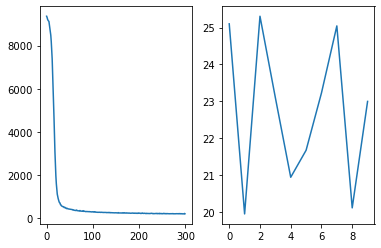

In [644]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(train_loss)
axes[1].plot(test_loss)
plt.savefig("sbm.svg")

In [641]:
test_loss

[26.5810753712103,
 26.00145764566546,
 25.525253295898438,
 25.563189645508427,
 26.20262561012153,
 24.9569956621333,
 21.588152391826686,
 22.578990658323967,
 24.904189392549906,
 21.873278392619223]

In [637]:
def train_mmoe():
    epochs = 300
    criterion = nn.MSELoss()
    train_loss = []
    test_loss = []
    mmoe = MMoE(12, 8, 8, 3, 5) 
    optimizer = torch.optim.AdamW(mmoe.parameters(), lr = 5e-4)
    for epoch in range(epochs):
        Loss = 0.0
        for data in train_loader:
            x, y = data
            optimizer.zero_grad()
            y1, y2, y3, y4, y5 = mmoe(x)
            loss = criterion(y1, y[:, 0].unsqueeze(-1)) + criterion(y2, y[:, 1].unsqueeze(-1)) + criterion(y3, y[:, 2].unsqueeze(-1)) + criterion(y4, y[:, 3].unsqueeze(-1)) + criterion(y5, y[:, 4].unsqueeze(-1))
            loss.backward()
            optimizer.step()
            Loss += loss.item()
        train_loss.append(Loss)
        with torch.no_grad():
            y1, y2, y3, y4, y5 = mmoe(X_test)
            test = (criterion(y1, y_test[:, 0].unsqueeze(-1)) + criterion(y2, y_test[:, 1].unsqueeze(-1)) + criterion(y3, y_test[:, 2].unsqueeze(-1)) + criterion(y4, y_test[:, 3].unsqueeze(-1)) + criterion(y5, y_test[:, 4].unsqueeze(-1))).item()
            test_loss.append(test)
        print("epoch: {}, batch loss: {}".format(epoch + 1, Loss / len(train_loader)))
    return np.array(test_loss[101:]).mean()

In [643]:
test_loss = []
for i in range(10):
    test_loss.append(train_sbm())
np.array(test_loss).mean()

epoch: 1, batch loss: 785.8115946451823
epoch: 2, batch loss: 778.9855804443359
epoch: 3, batch loss: 774.926259358724
epoch: 4, batch loss: 774.2130025227865
epoch: 5, batch loss: 769.5435994466146
epoch: 6, batch loss: 762.9115193684896
epoch: 7, batch loss: 755.5383961995443
epoch: 8, batch loss: 748.0529123942057
epoch: 9, batch loss: 739.8250172932943
epoch: 10, batch loss: 719.3639373779297
epoch: 11, batch loss: 699.974110921224
epoch: 12, batch loss: 672.7014312744141
epoch: 13, batch loss: 639.5906168619791
epoch: 14, batch loss: 588.3909861246744
epoch: 15, batch loss: 529.0458857218424
epoch: 16, batch loss: 471.8142344156901
epoch: 17, batch loss: 400.6237258911133
epoch: 18, batch loss: 332.39956919352215
epoch: 19, batch loss: 260.3936411539714
epoch: 20, batch loss: 213.66571299235025
epoch: 21, batch loss: 164.3678824106852
epoch: 22, batch loss: 134.91260846455893
epoch: 23, batch loss: 115.64458084106445
epoch: 24, batch loss: 97.73488807678223
epoch: 25, batch loss: 

22.74191952326789

In [639]:
test_loss = []
for i in range(10):
    test_loss.append(train_mmoe())
np.array(test_loss).mean()

epoch: 1, batch loss: 782.9950968424479
epoch: 2, batch loss: 786.8428904215494
epoch: 3, batch loss: 778.0479227701823
epoch: 4, batch loss: 774.3045298258463
epoch: 5, batch loss: 776.7972157796224
epoch: 6, batch loss: 767.0718078613281
epoch: 7, batch loss: 765.1491038004557
epoch: 8, batch loss: 766.7789204915365
epoch: 9, batch loss: 759.8102162679037
epoch: 10, batch loss: 751.0029907226562
epoch: 11, batch loss: 744.6490427652994
epoch: 12, batch loss: 735.577891031901
epoch: 13, batch loss: 723.8629862467448
epoch: 14, batch loss: 715.0005391438802
epoch: 15, batch loss: 696.0958607991537
epoch: 16, batch loss: 680.8677164713541
epoch: 17, batch loss: 657.8819122314453
epoch: 18, batch loss: 626.6165873209635
epoch: 19, batch loss: 596.5623474121094
epoch: 20, batch loss: 562.5684534708658
epoch: 21, batch loss: 531.9283981323242
epoch: 22, batch loss: 485.682378133138
epoch: 23, batch loss: 451.1513392130534
epoch: 24, batch loss: 404.78247833251953
epoch: 25, batch loss: 364

24.577520806585724

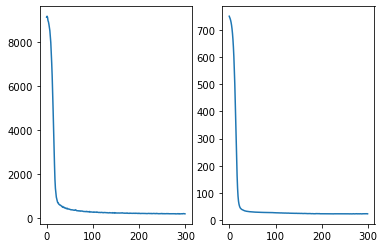

In [614]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(train_loss)
axes[1].plot(test_loss)

In [552]:
y1, y2, y3, y4, y5 = sbm(X_test)
criterion(y1, y_test[:, 0].unsqueeze(-1)) + criterion(y2, y_test[:, 1].unsqueeze(-1)) + criterion(y3, y_test[:, 2].unsqueeze(-1)) + criterion(y4, y_test[:, 3].unsqueeze(-1)) + criterion(y5, y_test[:, 4].unsqueeze(-1))

tensor(25.1554, grad_fn=<AddBackward0>)

In [550]:
y1, y2, y3, y4, y5 = mmoe(X_test)
criterion(y1, y_test[:, 0].unsqueeze(-1)) + criterion(y2, y_test[:, 1].unsqueeze(-1)) + criterion(y3, y_test[:, 2].unsqueeze(-1)) + criterion(y4, y_test[:, 3].unsqueeze(-1)) + criterion(y5, y_test[:, 4].unsqueeze(-1))

tensor(21.8366, grad_fn=<AddBackward0>)

In [551]:
X_test[0]

tensor([-1.2298e+00, -1.4372e-15, -1.0431e-15,  0.0000e+00,  3.5232e-13,
        -1.2255e+00, -1.9575e-01, -4.9312e-01,  5.2069e-02, -6.6861e-01,
         7.8489e-01,  1.2274e-01])

In [524]:
torch.save(mmoe, "mmoe.pkl")

In [549]:
mmoe = torch.load("mmoe.pkl")